## Project 1 (Due 2/17)

The goal of the first project is to do some wrangling, EDA, and visualization, and generate sequences of values. We will focus on:

- CDC National Health and Nutritional Examination Survey (NHANES, 1999-2000): https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=1999
- CDC Linked Mortality File (LMF, 1999-2000): https://www.cdc.gov/nchs/data-linkage/mortality-public.htm

NHANES is a rich panel dataset on health and behavior, collected bi-yearly from around 1999 to now. We will focus on the 1999 wave, because that has the largest follow-up window, providing us with the richest mortality data. The mortality data is provided by the CDC Linked Mortality File. 

The purpose of the project is to use $k$-NN to predict who dies (hard or soft classification) and how long they live (regression).

### Day 1: Wrangling and EDA (40/100 pts)

First, go to the NHANES and LMF web sites and familiarize yourself with the data sources. Download codebooks. Think about what resources are available. The CDC Linked Mortality File is somewhat of a pain to work with, so I have pre-cleaned it for you. It is available at httts://github.com/ds4e/undergraduate_ml_assignments in the data folder, as `lmf_parsed.cav`. From the CDC LMF web page, get the SAS program to load the data; it is the real codebook.

Second, download the demographic data for the 1999--2000 wave from the NHANES page. You can use the following code chunk to merge the LMF and DEMO data:

``` python
import pandas as pd
mdf = pd.read_csv('lmf_parsed.csv') # Load mortality file
print( mdf.head() )
gdf = pd.read_sas("DEMO.xpt", format="xport") # Load demographics file
print( gdf.head() )
df = gdf.merge(mdf, on="SEQN", how="inner") # Merge mortality and demographics on SEQN variable
```

Third, the variables `ELIGSTAT`, `MORTSTAT`, `PERMTH_INT`, and `RIDAGEEX` are particularly important. Look them up in the documentation and clearly describe them. (5/100 pts.)

Second, the goal of the project is to use whatever demographic, behavioral, and health data you like to predict mortality (`MORTSTAT`) and life expectancy (`PERMTH_INT`). Go to the NHANES 1999--2000 web page and select your data and download it. Clearly explain your rationale for selecting these data. Use `.merge` to combine your data into one complete dataframe. Document missing values. (5/100 pts)

Third, do basic EDA and visualization of the key variables. Are any important variables skewed? Are there outliers? How correlated are pairs of variables? Do pairs of categorical variables exhibit interesting patterns in contingency tables? Provide a clear discussion and examination of the data and the variables you are interested in using. (20/100 pts)


### Day 2: $k$-NN classification/regression, write-up (50/100 pts)

Submit a notebook that clearly addresses the following, using code and markdown chunks:

1. Describe the data, particularly what an observation is and whether there are any missing data that might impact your analysis. Who collected the data and why? What known limitations are there to analysis? (10/100 pts)
2. Describe the variables you selected to predict mortality and life expectancy, and the rationale behind them. Analyze your variables using describe tables, kernel densities, scatter plots, and conditional kernel densities. Are there any patterns of interest to notice? (10/100 pts)
3. Using your variables to predict mortality using a $k$-Nearest Neighbor Classifier. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
4. Using your variables to predict life expectancy using a $k$-Nearest Neighbor Regressor. Analyze its performance and explain clearly how you select $k$. (10/100 pts)
5. Describe how your model could be used for health interventions based on patient characteristics. Are there any limitations or risks to consider? (10/100 pts)

## Submission (10/100 pts)

Submit your work in a well-organized GitHub repo, where the code is appropriately commented and all members of the group have made significant contributions to the commit history. (10/100 pts)

### Submission: Day 1

First we begin with loading the two datasets (DEMO.xpt and linked_mortality_file_1999_2000.csv)

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [142]:
# Load linked mortality file and the DEMO.xpt file
mdf = pd.read_csv("data/linked_mortality_file_1999_2000.csv")
print("Mortality file:", mdf.shape)
print(mdf.head())
gdf = pd.read_sas("data/DEMO.xpt", format="xport")
print("Demo file:", gdf.shape)
print(gdf.head())
# Merge
df = gdf.merge(mdf, on="SEQN", how="inner")
print("Merged:", df.shape)
df.head()

Mortality file: (9965, 8)
   SEQN  ELIGSTAT  MORTSTAT  UCOD_LEADING  DIABETES  HYPERTEN  PERMTH_INT  \
0     1         2       NaN           NaN       NaN       NaN         NaN   
1     2         1       1.0           6.0       0.0       0.0       177.0   
2     3         2       NaN           NaN       NaN       NaN         NaN   
3     4         2       NaN           NaN       NaN       NaN         NaN   
4     5         1       0.0           NaN       NaN       NaN       244.0   

   PERMTH_EXM  
0         NaN  
1       177.0  
2         NaN  
3         NaN  
4       244.0  
Demo file: (9965, 144)
   SEQN  SDDSRVYR  RIDSTATR  RIDEXMON  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDAGEEX  \
0   1.0       1.0       2.0       2.0       2.0       2.0      29.0      31.0   
1   2.0       1.0       2.0       2.0       1.0      77.0     926.0     926.0   
2   3.0       1.0       2.0       1.0       2.0      10.0     125.0     126.0   
3   4.0       1.0       2.0       2.0       1.0       1.0      22.0 

,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,WTIREP50,WTIREP51,WTIREP52,ELIGSTAT,MORTSTAT,UCOD_LEADING,DIABETES,HYPERTEN,PERMTH_INT,PERMTH_EXM
0,1.0,1.0,2.0,2.0,2.0,2.0,29.0,31.0,4.0,2.0,...,10327.992682,9809.165049,10323.315747,2,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,27268.025234,27406.383620,26984.812909,1,1.0,6.0,0.0,0.0,177.0,177.0
2,3.0,1.0,2.0,1.0,2.0,10.0,125.0,126.0,3.0,1.0,...,44480.987235,45389.112766,43781.905637,2,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,1.0,2.0,2.0,1.0,1.0,22.0,23.0,4.0,2.0,...,10851.024385,10564.981435,11012.529729,2,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,92817.926915,94282.855382,91993.251203,1,0.0,NaN,NaN,NaN,244.0,244.0


1. `ELIGSTAT`:This variable tells you whether a survey participant was eligible to be linked to mortality (death) records in the National Death Index (NDI):

1 = Eligible: The participant had sufficient identifying information to be linked to death records.

2 = Under age 18 (not released): The participant was under age 18 and thus not included in the public-use mortality linkage.

3 = Ineligible: The participant did not have enough identifying information to perform the mortality linkage.

2. `MORTSTAT` :This variable indicates the vital status of a participant (whether they are counted as alive or deceased) after linkage to mortality data:

0 = Assumed alive: The participant was eligible for linkage and was not found to be deceased in the linked mortality data.

1 = Assumed deceased: The participant was eligible and a match to a death record was found.

Blank/missing: Not eligible for linkage (e.g., too young or insufficient records).

3. `PERMTH_INT`: This variable measures the total number of months the participant was followed for mortality outcomes starting from the survey interview date until:

the date of death, if deceased; or

the end of the mortality follow-up period (e.g., Dec 31, 2019 for public-use linked data).

4. `RIDAGEEX` : The age of the respondent at the time of their NHANES examination in months.

In [143]:
smq = pd.read_sas("data/SMQ.xpt", format="xport")
print("Smoking file:", smq.shape)

duq = pd.read_sas("data/DUQ.xpt", format="xport")
print("Drug Use file:", duq.shape)

df = df.merge(smq, on="SEQN", how="left")
df = df.merge(duq, on="SEQN", how="left")

print("Final merged dataset:", df.shape)


Smoking file: (4880, 39)
Drug Use file: (2838, 5)
Final merged dataset: (9965, 193)


In [144]:
print(df.isna().sum())

SEQN           0
SDDSRVYR       0
RIDSTATR       0
RIDEXMON     683
RIAGENDR       0
            ... 
SMD235      9945
DUQ100      7360
DUQ110      9483
DUQ120      9483
DUQ130      9914
Length: 193, dtype: int64


1. We chose Drug Use and Smoking because we wanted to see how much these impact mortality rates and life expectancy.

In [145]:
# filtering out records that are not eligible for linkage (without a valid MORTSTAT) 
df_linked = df[df["MORTSTAT"].notna()]
print(df_linked.shape)
df_linked.head()

(5445, 193)


,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,SMQ205,SMQ210,SMD220,SMQ230,SMD233,SMD235,DUQ100,DUQ110,DUQ120,DUQ130
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,NaN,1.0,5.397605e-79,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,6.0,1.0,2.0,2.0,2.0,19.0,230.0,230.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,1.0,2.0,2.0,2.0,59.0,712.0,712.0,4.0,2.0,...,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
9,10.0,1.0,2.0,2.0,1.0,43.0,518.0,518.0,4.0,2.0,...,NaN,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN


#### Age

In [146]:
print(df_linked["RIDAGEEX"].isna().sum() / df_linked.shape[0])

0.1111111111111111


In [147]:
df_age_notna = df_linked[df_linked["RIDAGEEX"].notna()]
((df_age_notna["RIDAGEEX"] // 12) - df_age_notna["RIDAGEYR"]).value_counts()

0.0    4494
1.0     346
Name: count, dtype: int64

Records with missing `RIDAGEEX` values account for only 11% of the data. Additionally, for records with a `RIDAGEEX` value, that value only differs from `RIDAGEYR` by at most one year. Therefore, we set the `CLEANED_AGE` of each patient to be `RIDAGEEX` in years, and if this value is missing, then set to `RIDAGEYR`.

In [148]:
df_linked["CLEANED_AGE"] = np.where(df_linked["RIDAGEEX"].notna(), df_linked["RIDAGEEX"] // 12, df_linked["RIDAGEYR"])
df_linked.head()

/var/folders/y8/wry3hv5d7tbfh2t867pyg9_r0000gn/T/ipykernel_42362/2158176905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["CLEANED_AGE"] = np.where(df_linked["RIDAGEEX"].notna(), df_linked["RIDAGEEX"] // 12, df_linked["RIDAGEYR"])


,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,SMQ210,SMD220,SMQ230,SMD233,SMD235,DUQ100,DUQ110,DUQ120,DUQ130,CLEANED_AGE
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,1.0,5.397605e-79,NaN,NaN,NaN,2.0,NaN,NaN,NaN,49.0
5,6.0,1.0,2.0,2.0,2.0,19.0,230.0,230.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0
6,7.0,1.0,2.0,2.0,2.0,59.0,712.0,712.0,4.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,59.0
9,10.0,1.0,2.0,2.0,1.0,43.0,518.0,518.0,4.0,2.0,...,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,43.0


In [149]:
df_linked["CLEANED_AGE"].describe()

count    5445.000000
mean       47.264646
std        20.684510
min        18.000000
25%        29.000000
50%        45.000000
75%        65.000000
max        85.000000
Name: CLEANED_AGE, dtype: float64

<Axes: xlabel='CLEANED_AGE', ylabel='Count'>

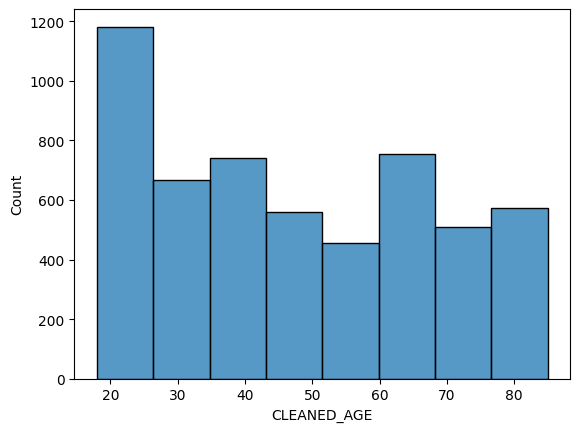

In [150]:
sns.histplot(df_linked["CLEANED_AGE"], bins=8)

Survey participant ages are skewed right, with a plurality of participants being around their early 20s.

#### Drug Use

From the drug use dataset `DUQ`, only the feature `DUQ100`, renamed as `used_street_drug`, had enough responses to be significant, with around 48% of records having a non-null value. All other features in `DUQ` had less than 10% non-null values.

`DUQ100` was converted from float to string.

In [152]:
df_linked["DUQ100_na"] = df_linked["DUQ100"].isna()
df_linked["used_street_drug"] = np.where(df_linked["DUQ100"].notna(), df_linked["DUQ100"].astype("Int64").astype("str"), "Missing")

/var/folders/y8/wry3hv5d7tbfh2t867pyg9_r0000gn/T/ipykernel_42362/2414763143.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["DUQ100_na"] = df_linked["DUQ100"].isna()
/var/folders/y8/wry3hv5d7tbfh2t867pyg9_r0000gn/T/ipykernel_42362/2414763143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_linked["used_street_drug"] = np.where(df_linked["DUQ100"].notna(), df_linked["DUQ100"].astype("Int64").astype("str"), "Missing")


In [154]:
pd.crosstab(df_linked["MORTSTAT"], df_linked["used_street_drug"])

used_street_drug,1,2,7,9,Missing
MORTSTAT,,,,,
0.0,414,1898,5,6,1447
1.0,67,208,1,3,1396


<Axes: xlabel='PERMTH_INT', ylabel='Density'>

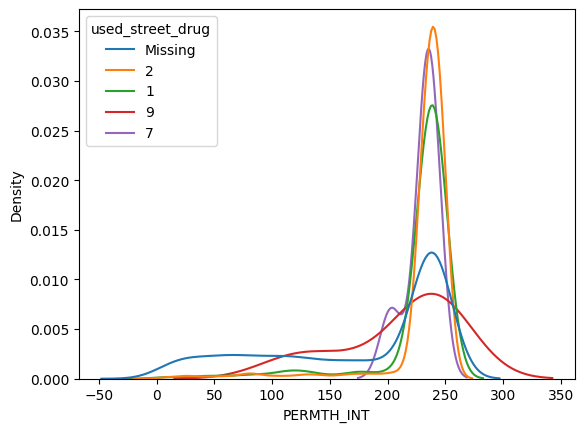

In [155]:
sns.kdeplot(df_linked, x="PERMTH_INT", hue="used_street_drug", common_norm=False)

Of those participants who have never used street drugs (coded as 2), 90% of them are assumed alive. Of those particpants who have used street drugs (coded as 1), 86% of them are assumed alive.

#### Smoking

In [153]:
df_linked.head()

,SEQN,SDDSRVYR,RIDSTATR,RIDEXMON,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDAGEEX,RIDRETH1,RIDRETH2,...,SMQ230,SMD233,SMD235,DUQ100,DUQ110,DUQ120,DUQ130,CLEANED_AGE,DUQ100_na,used_street_drug
1,2.0,1.0,2.0,2.0,1.0,77.0,926.0,926.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,True,Missing
4,5.0,1.0,2.0,2.0,1.0,49.0,597.0,597.0,3.0,1.0,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,49.0,False,2
5,6.0,1.0,2.0,2.0,2.0,19.0,230.0,230.0,5.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,True,Missing
6,7.0,1.0,2.0,2.0,2.0,59.0,712.0,712.0,4.0,2.0,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,59.0,False,2
9,10.0,1.0,2.0,2.0,1.0,43.0,518.0,518.0,4.0,2.0,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,43.0,False,2
